# Imports

In [ ]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/tf/ProjectGabriel/pilca")

import numpy as np
import pandas as pd
from lightcurve_fitting import models, filters, lightcurve
import matplotlib.pyplot as plt
import matplotlib as mpl
import importlib
from utils.utils import load_lc
from utils.utils import light_curve_plot
import torch
import utils.torchphysics as tp
import utils.utils as ut
# import lc
import os
torch.set_default_dtype(torch.float64)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setting light curve

## importing fake light curve

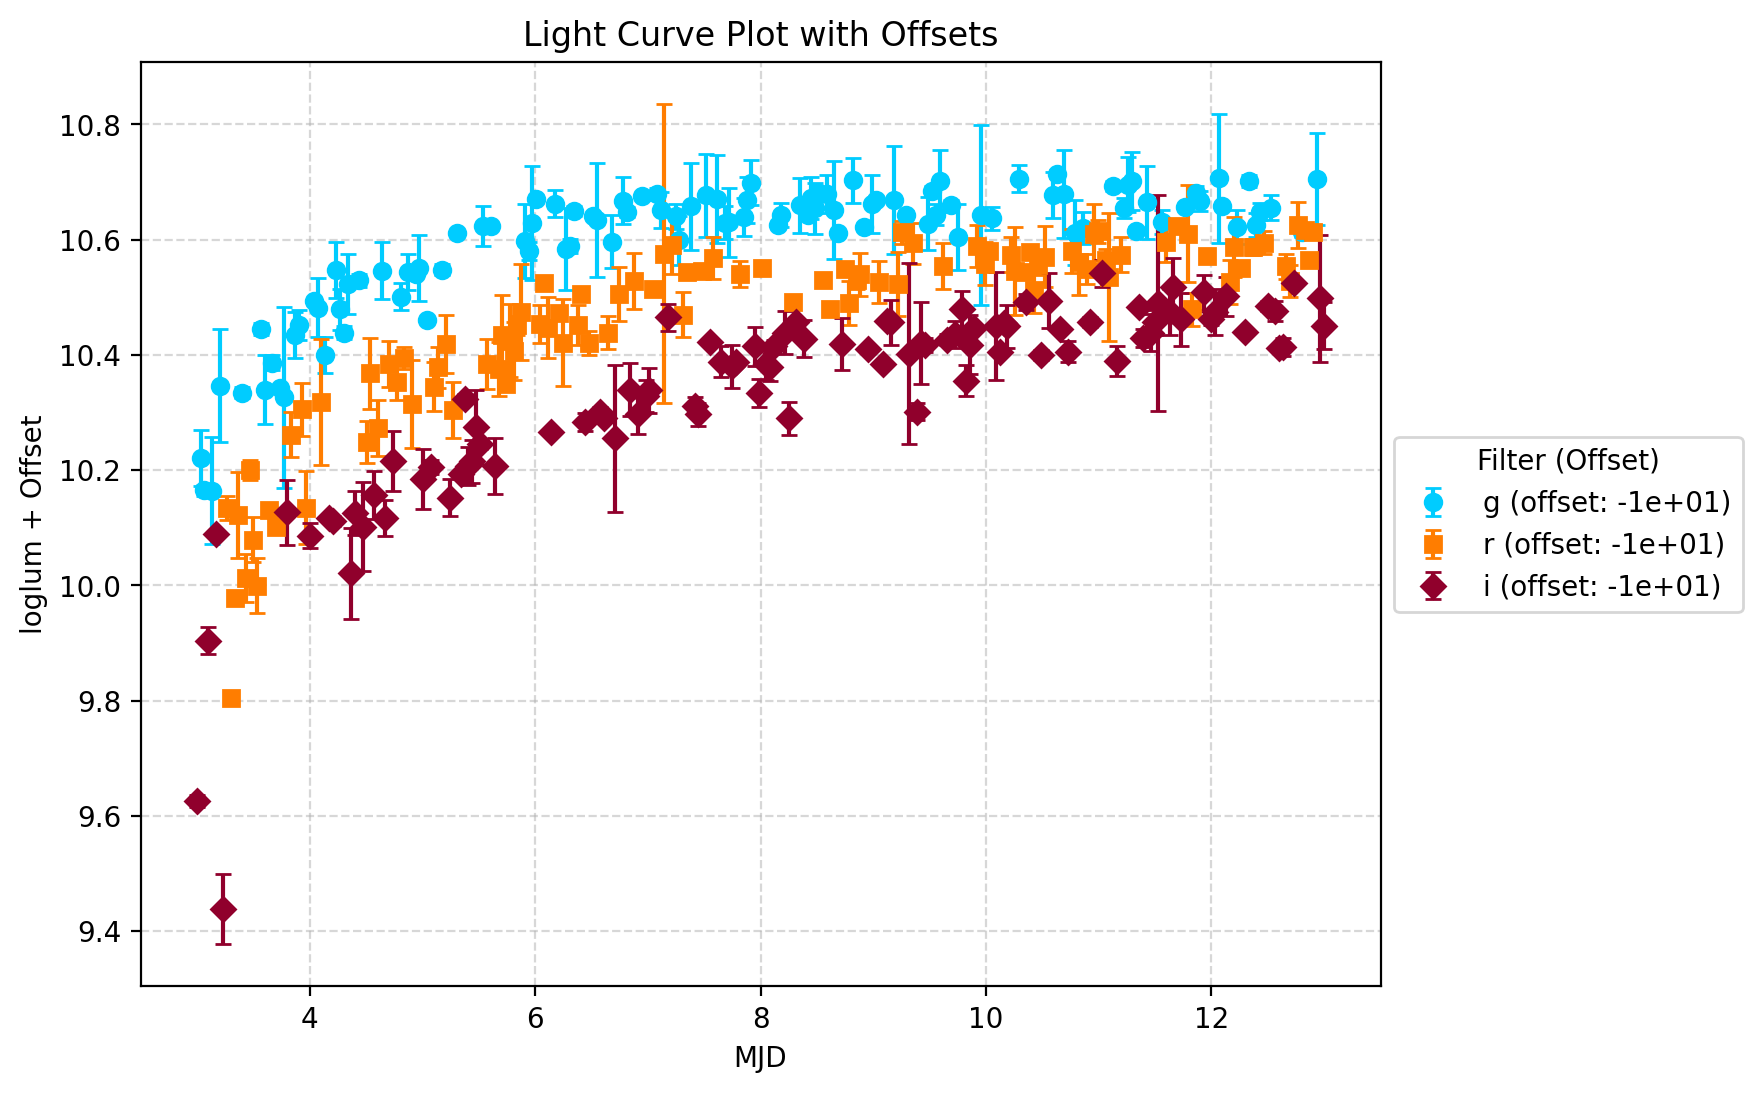

In [20]:
builder = ut.LCBuilder()
lc = builder.build_sim_lc()
light_curve_plot(lc, offset = .05, ycol="loglum")

## importing real light curve

In [21]:
# lc_dir = os.path.join("../data/2022acko", "2022acko_total.dat")
# lc = load_lc(lc_dir=lc_dir)
# lc.calcAbsMag()
# lc.calcLum()
# light_curve_plot(lc, ycol="lum")


## Setting torch objects

In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

torchenizer = tp.Torchenizer(lc, ycol="loglum", device=device)

X_DATA, filters_mask, ufilters = torchenizer.get_xdata(max_phase=8, t0_offset=3)

Using device: cuda


# Setting Model
and training

In [ ]:
nn_model_name = "bnn_pilca.pth"
model_save_dir = os.path.join(ut.storage_parent_path, "models", nn_model_name)

nn_model = tp.MultiFilterBNN(x_data=X_DATA,
                            filters_mask=filters_mask,
                            param_dim=4,
                            hidden_dim=32).to(device)

criterion = tp.ModifiedSC4Loss(ufilters=ufilters,
                               z=lc.meta["redshift"],
                               mode="mean_param")
lr=1e-3
optimizer = torch.optim.Adam(nn_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                            step_size=1000, gamma=0.5)

trainer = tp.Trainer(model=nn_model,
                    criterion=criterion,
                    epochs=5000,
                    n_samples_loss=50,
                    optimizer=optimizer,
                    scheduler=scheduler,
                    verbose_step=100,
                    save_dir=model_save_dir)

trainer.train()

--- Step 0 ---
Shock velocity (v_s):     2.3336
Envelope mass (M_env):    7.0846
Density factor (f_rho_M): 7.0846
Radius (R):               2.2901
Explosion time (t_exp):   1.4295
Loss:                     0.285925
----------------------------------------
--- Step 100 ---
Shock velocity (v_s):     1.5819
Envelope mass (M_env):    2.6032
Density factor (f_rho_M): 2.6032
Radius (R):               2.0734
Explosion time (t_exp):   2.6348
Loss:                     0.004046
----------------------------------------
--- Step 200 ---
Shock velocity (v_s):     1.4639
Envelope mass (M_env):    2.4828
Density factor (f_rho_M): 2.4828
Radius (R):               3.0051
Explosion time (t_exp):   2.4551
Loss:                     0.007299
----------------------------------------
--- Step 300 ---
Shock velocity (v_s):     1.3329
Envelope mass (M_env):    2.1924
Density factor (f_rho_M): 2.1924
Radius (R):               3.5493
Explosion time (t_exp):   2.6150
Loss:                     0.003175
-----------

In [91]:
torch.save(nn_model.state_dict(), "test.pth")

In [108]:
nnnnnew_nnmodel = tp.MultiFilterBNN(x_data=X_DATA,
                            filters_mask=filters_mask,
                            param_dim=4,
                            hidden_dim=32).to(device)

In [111]:
nnnnnew_nnmodel.load_state_dict(torch.load("test.pth"))


<All keys matched successfully>

In [ ]:
nnnnnew_nnmodel()

tensor([1.2697, 2.1947, 4.6172, 1.9691], device='cuda:0',
       grad_fn=<SqueezeBackward1>)

In [112]:
samples = []
for i in range(1000):
    samples.append(nnnnnew_nnmodel())
samples = torch.stack(samples).detach().cpu().numpy() # shape [N_samples, 5]

print(samples.shape)


(1000, 4)


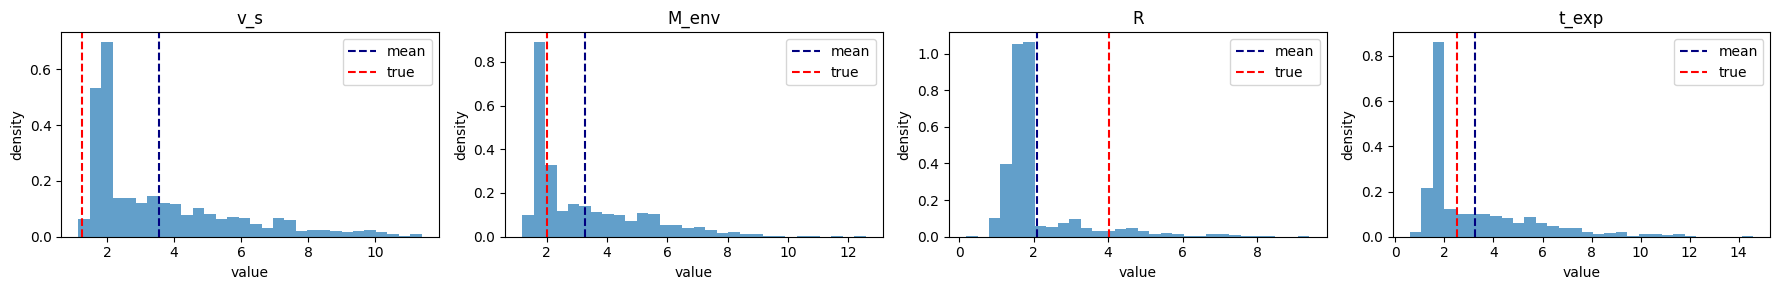

In [110]:
param_names = ["v_s", "M_env",  "R", "t_exp"]
mean = samples.mean(0)
std = samples.std(0)
true = builder.model_parameters
fig, axes = plt.subplots(1, 4, figsize=(18, 3))
for i, name in enumerate(param_names):
    axes[i].hist(samples[:, i], bins=30, density=True, color="tab:blue", alpha=0.7)
    axes[i].axvline(mean[i], color="navy", linestyle="--", label="mean")
    axes[i].axvline(true[i], color="red", linestyle="--", label="true")

    axes[i].set_title(name)
    axes[i].set_xlabel("value")
    axes[i].set_ylabel("density")
    axes[i].legend()

plt.tight_layout()
plt.show()